## Digit Recognizer

### Learn computer vision fundamentals with the famous MNIST data.

__CNN__ and other parts of the model was taken from **Digit Recognizer_CNN**

__Rank:__ Top __25__ with __Score:__ 1.00000 in the Kaggle Competitions.

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import RandomTranslation, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import SGD

from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import to_categorical

from numpy.random import seed
from tensorflow.random import set_seed
from keras.datasets import mnist

In [2]:
SIZE = 28
SEED = 17

set_seed(SEED)
seed(SEED)

### This is the **cheating** cell

In [3]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
X_train = np.concatenate((X_train_raw, X_test_raw))
y_train = np.concatenate((y_train_raw, y_test_raw))

print(X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape)
print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(70000, 28, 28) (70000,)


In [5]:
valid = pd.read_csv('../input/digit-recognizer/train.csv').to_numpy()
test = pd.read_csv('../input/digit-recognizer/test.csv').to_numpy()
print(valid.shape, test.shape)

(42000, 785) (28000, 784)


In [6]:
train_Y = to_categorical(y_train)
valid_Y = to_categorical(valid[:,0])


train_X = X_train / 255.0
valid_X = valid[:,1:] / 255.0
test_X = test / 255.0

train_X = train_X.reshape(-1, SIZE, SIZE, 1)
valid_X = valid_X.reshape(-1, SIZE, SIZE, 1)
test_X = test_X.reshape(-1, SIZE, SIZE, 1)


print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape, test_X.shape)

(70000, 28, 28, 1) (70000, 10) (42000, 28, 28, 1) (42000, 10) (28000, 28, 28, 1)


In [7]:
BS = 64
EPOCHS = 50

STEPS = len(train_X) // BS
LABELS = 10

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_X, valid_Y))

train_ds = train_ds.shuffle(STEPS * BS).batch(BS).repeat().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BS)

In [9]:
class Model:
    @staticmethod
    def build(height, width, depth):
        model = keras.Sequential()
        
        #Input
        model.add(Input((height, width, depth)))

        #CNN layers
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        
        model.add(Flatten())
        
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(10, activation = 'softmax'))
        
        return model

In [10]:
model = Model.build(SIZE, SIZE, 1)
model.summary()

optimizer = SGD(learning_rate = 5e-4)

early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 1e-3,
    restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

LR = LearningRateScheduler(scheduler)

model.compile(
    optimizer = 'SGD',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    steps_per_execution = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [11]:
%%time
H = model.fit(
train_ds, validation_data = valid_ds,
epochs=EPOCHS,
steps_per_epoch = STEPS,
callbacks = [early_stopping, LR])

Epoch 1/50
1093/1093 [==============================] - 22s 11ms/step - loss: 0.1331 - accuracy: 0.9671 - val_loss: 0.0423 - val_accuracy: 0.9898 - lr: 0.0100
Epoch 2/50
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0407 - accuracy: 0.9889 - val_loss: 0.0297 - val_accuracy: 0.9923 - lr: 0.0100
Epoch 3/50
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0274 - accuracy: 0.9928 - val_loss: 0.0217 - val_accuracy: 0.9947 - lr: 0.0100
Epoch 4/50
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0191 - accuracy: 0.9954 - val_loss: 0.0136 - val_accuracy: 0.9972 - lr: 0.0100
Epoch 5/50
1093/1093 [==============================] - 12s 11ms/step - loss: 0.0144 - accuracy: 0.9968 - val_loss: 0.0088 - val_accuracy: 0.9984 - lr: 0.0100
Epoch 6/50
1093/1093 [==============================] - 11s 10ms/step - loss: 0.0108 - accuracy: 0.9978 - val_loss: 0.0066 - val_accuracy: 0.9992 - lr: 0.0100
Epoch 7/50
1093/1093 [========================

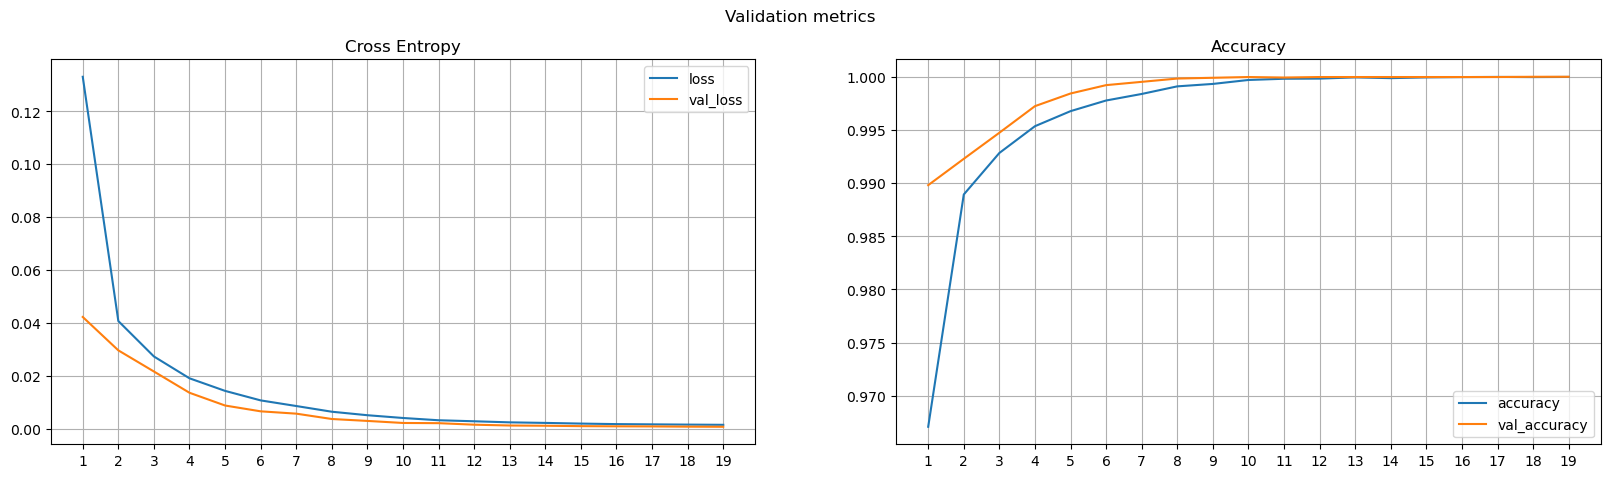

In [12]:
df = pd.DataFrame(H.history)
df.index += 1
fig = plt.figure(figsize = (20,5))
fig.suptitle('Validation metrics')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks(range(len(df)+1))
ax2.set_xticks(range(len(df)+1))
df[['loss', 'val_loss']].plot(title="Cross Entropy", grid=True, ax=ax1)
df[['accuracy', 'val_accuracy']].plot(title="Accuracy",grid=True, ax=ax2)
plt.show()

In [13]:
model.save('model.h5', save_format='h5')

In [14]:
pred = model.predict(test_X)
classes = pred.argmax(axis=-1)

sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
sub.Label = classes
sub.head()

875/875 [==============================] - 3s 3ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [15]:
sub.to_csv('submission.csv', index = False)